In [36]:
from parcels import FieldSet, ParticleSet, AdvectionRK4_3D, AdvectionRK4, ParticleFile, JITParticle, StatusCode, Variable
import numpy as np
import xarray as xr
from glob import glob
from datetime import timedelta as delta
import matplotlib.pyplot as plt
import h3
import cartopy

import pickle
import sys
sys.path.append('../functions')
import hexbin_functions as hexfunc

In [37]:
with open('../data/hexgrid_no_coast.pkl', 'rb') as f:
    hexagons_grid = pickle.load(f)
    
grid = hexfunc.hexGrid(hexagons_grid)

In [3]:
class EnsembleParticle(JITParticle):
    """
    Particle class definition with additional variables
    """
    # dynamic variables
    u = Variable('u', dtype=np.float32, initial=0)
    v = Variable('v', dtype=np.float32, initial=0)
    w = Variable('w', dtype=np.float32, initial=0)
    
    hexbin_id = Variable('hexbin_id', dtype=np.int16, initial=0)

In [4]:
def SampleField(particle, fieldset, time):
    """
    Sample the fieldset at the particle location and store it in the
    particle variable.
    """
    (ui, vi, wi) = fieldset.UVW.eval(time, particle.depth, particle.lat, particle.lon, 
                                     particle=particle, applyConversion=False)
    particle.u = ui
    particle.v = vi
    particle.w = wi

In [147]:
loc1_lon = -74.0
loc1_lat = 35.5

# Find the hexagon containing the location

loc1_hex = h3.geo_to_h3(loc1_lat, loc1_lon, 3)

loc1_lat, loc1_lon = h3.h3_to_geo(loc1_hex)

lon_0 = loc1_lon
lat_0 = loc1_lat

# Define the rings where we place the particles
L_range = np.arange(0.01, 1.5, 0.01)
theta_range = np.arange(0, 2*np.pi, np.pi/40)
lonp = [lon_0]
latp = [lat_0]

R_members = np.zeros((50, len(L_range)))

for member in range(1, 51):
    print(f"Member {member}")

    data_path = '/storage/shared/oceanparcels/input_data/NEMO_Ensemble/'
    ufiles = sorted(glob(f"{data_path}NATL025-CJMCYC3.{member:03d}-S/1d/2010/NATL025*U.nc"))
    vfiles = [f.replace('U.nc', 'V.nc') for f in ufiles]
    wfiles = [f.replace('U.nc', 'W.nc') for f in ufiles]
    mesh_mask = f"{data_path}GRID/coordinates_NATL025_v2.nc"
    maskfile = f"{data_path}GRID/NATL025-CJMenobs01_byte_mask.nc"

    filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
                'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
                'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles},
                'mask': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': maskfile}}
    variables = {'U': 'vozocrtx', 'V': 'vomecrty', 'W': 'vovecrtz', 'mask': 'fmask'}
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'mask': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw'}}

    fieldset = FieldSet.from_nemo(filenames, variables, dimensions, netcdf_decodewarning=False)
        
    for r in L_range:    
        for theta in theta_range:
            lonp.append(lon_0 + np.sin(theta)*r) 
            latp.append(lat_0 + np.cos(theta)*r)

    end_time = np.datetime64('2010-01-02') + np.timedelta64(1, 'h')
    times = [np.datetime64('2010-01-02')]*len(lonp)
    depp = np.ones(len(lonp))
    pset = ParticleSet(fieldset, EnsembleParticle, lon=lonp, lat=latp, depth=depp, time=times)
        
    pset.execute([SampleField], 
                dt=delta(hours=1), endtime=end_time)

    u0 = pset.u[0]
    v0 = pset.v[0]
    R_values = []
    particles_per_ring = len(theta_range)

    for i in range(len(L_range)):
        
        j = i*particles_per_ring + 1
        k = (i + 1)*particles_per_ring + 1
        # print(j, k, len(pset.u[j:k]),  k-j == len(pset.u[j:k]))
        
        rho1 = np.mean(pset.u[j:k]*u0 + pset.v[j:k]*v0)
        uvar = np.mean((pset.u[j:k])**2 + (pset.v[j:k])**2) 

        R = rho1/(uvar)
        R_values.append(R)
        
    R_members[member-1, :] = np.array(R_values)
    


Member 1
100%|██████████| 3600.0/3600.0 [00:00<00:00, 20611.17it/s]
Member 2
100%|██████████| 3600.0/3600.0 [00:00<00:00, 14338.92it/s]
Member 3
100%|██████████| 3600.0/3600.0 [00:00<00:00, 11104.46it/s]
Member 4
100%|██████████| 3600.0/3600.0 [00:00<00:00, 9030.03it/s]
Member 5
100%|██████████| 3600.0/3600.0 [00:00<00:00, 7606.62it/s]
Member 6
100%|██████████| 3600.0/3600.0 [00:00<00:00, 6781.76it/s]
Member 7
100%|██████████| 3600.0/3600.0 [00:00<00:00, 5975.56it/s]
Member 8
100%|██████████| 3600.0/3600.0 [00:00<00:00, 5327.46it/s]
Member 9
100%|██████████| 3600.0/3600.0 [00:00<00:00, 4827.65it/s]
Member 10
100%|██████████| 3600.0/3600.0 [00:00<00:00, 4336.00it/s]
Member 11
100%|██████████| 3600.0/3600.0 [00:00<00:00, 4036.92it/s]
Member 12
100%|██████████| 3600.0/3600.0 [00:00<00:00, 3712.76it/s]
Member 13
100%|██████████| 3600.0/3600.0 [00:01<00:00, 3469.92it/s]
Member 14
100%|██████████| 3600.0/3600.0 [00:01<00:00, 3246.76it/s]
Member 15
100%|██████████| 3600.0/3600.0 [00:01<00:00,

IndexError: index 50 is out of bounds for axis 0 with size 50

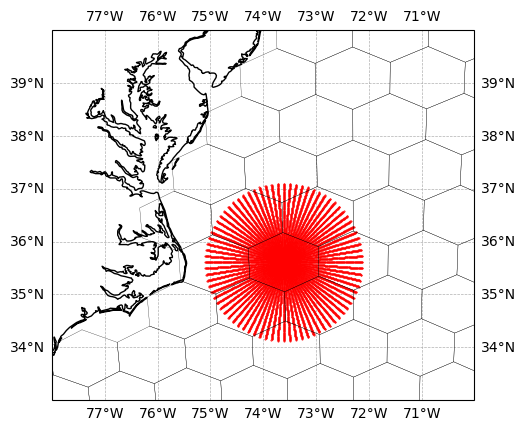

In [142]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-78, -70, 33, 40], crs=cartopy.crs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

hexfunc.plot_hexagons(ax, hexagons_grid, colors='r', draw_edges=True, fill_polygons=False)

ax.scatter(pset.lon, pset.lat, 
           transform=cartopy.crs.PlateCarree(), s=0.2, c='r')

In [143]:
u0 = pset.u[0]
v0 = pset.v[0]
R_values = []
particles_per_ring = len(theta_range)

for i in range(len(L_range)):
    
    j = i*particles_per_ring + 1
    k = (i + 1)*particles_per_ring + 1
    # print(j, k, len(pset.u[j:k]),  k-j == len(pset.u[j:k]))
    
    rho1 = np.mean(pset.u[j:k]*u0 + pset.v[j:k]*v0)
    uvar = np.mean((pset.u[j:k])**2 + (pset.v[j:k])**2) 

    R = rho1/(uvar)
    R_values.append(R)
    
R_values = np.array(R_values)

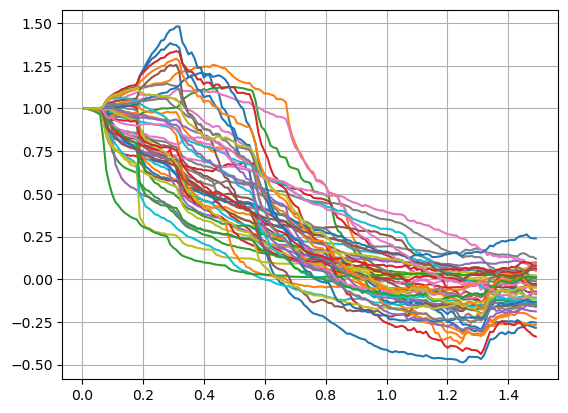

In [152]:
for member in range(1, 50):
    plt.plot(L_range, R_members[member,:])
    
plt.grid()

In [96]:
end_time = np.datetime64('2010-01-02') + np.timedelta64(1, 'h')
pset.execute([SampleField], 
             dt=delta(hours=1), endtime=end_time)
# pset.execute([SampleField], dt=delta(hours=1))

100%|██████████| 3600.0/3600.0 [00:00<00:00, 36148.96it/s]


In [97]:
pset

P[1458](lon=-73.611843, lat=35.609134, depth=1.000000, u=0.000002, v=-0.000003, w=-0.000001, hexbin_id=0.000000, time=43200.000000)
P[1459](lon=-73.611843, lat=36.409134, depth=1.000000, u=0.000001, v=-0.000003, w=-0.000002, hexbin_id=0.000000, time=43200.000000)
P[1460](lon=-73.549076, lat=36.406668, depth=1.000000, u=0.000001, v=-0.000003, w=-0.000002, hexbin_id=0.000000, time=43200.000000)
P[1461](lon=-73.486695, lat=36.399284, depth=1.000000, u=0.000001, v=-0.000004, w=-0.000002, hexbin_id=0.000000, time=43200.000000)
P[1462](lon=-73.425087, lat=36.387030, depth=1.000000, u=0.000001, v=-0.000003, w=0.000004, hexbin_id=0.000000, time=43200.000000)
P[1463](lon=-73.364629, lat=36.369979, depth=1.000000, u=0.000000, v=-0.000003, w=0.000004, hexbin_id=0.000000, time=43200.000000)
P[1464](lon=-73.305696, lat=36.348237, depth=1.000000, u=-0.000000, v=-0.000003, w=0.000004, hexbin_id=0.000000, time=43200.000000)
P[1465](lon=-73.248650, lat=36.321939, depth=1.000000, u=-0.000001, v=-0.00000

In [ ]:

# # Plot NA_domain on a map
# depth = 0
# fig = plt.figure()
# ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.set_extent([-78, -70, 33, 40], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
# ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

# hexfunc.plot_hexagons(ax, hexagons_grid, colors='r', draw_edges=True, fill_polygons=False)

# ax.scatter(pset.lon, pset.lat, 
#            transform=cartopy.crs.PlateCarree(), s=1, c='r')

In [98]:
u0 = pset.u[0]
v0 = pset.v[0]


rho1 = np.mean(pset.u[1:]*u0 + pset.v[1:]*v0)
umean = np.mean(pset.u[1:] + pset.v[1:])**2

uvar = np.mean((pset.u[1:])**2 + (pset.v[1:])**2) 

R = rho1/(uvar)

print(R)

# # for i in range(1, len(pset)):
# #     rho1 += (pset.u[i]*u0 + pset.v[i]*v0)
# #     uvar += (pset.u[i]**2 + pset.v[i]**2)
# #     uu += (pset.u[i]+ pset.v[i])
    
# # for i in range(1, len(pset)):
# #     rho1 += (pset.u[i]*u0)
# #     uvar += (pset.u[i]**2)
# #     uu += (pset.u[i])

# rho1 /= len(pset)-2
# uvar /= len(pset)-2
# umean /= len(pset)-2

# R = rho1

# rho /= len(pset)-1
# rho    

0.14803609


1.6897246796210296e-11

In [22]:
np.variance



AttributeError: module 'numpy' has no attribute 'variance'